## Modèle SVM

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle

# Charger les données
file = open('dataset.pkl', 'rb')
DATA = pickle.load(file)
pheno = DATA['pheno']
X_gpa = DATA['X_gpa']
X_snps = DATA['X_snps']
X_genexp = DATA['X_genexp']

Fonction pour svm

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score


def refine_and_evaluate_with_grid_search(pheno, X_gpa, X_snps, X_genexp, model, param_grid):
    performances = []  # Liste pour stocker les performances par antibiotique
    colonnes_selectionnees = []  # Liste pour stocker les colonnes sélectionnées
    hyperparams_records = []  # Pour stocker les informations sur les hyperparamètres

    # Pour chaque antibiotique
    for antibiotique in pheno.columns[1:]:  
        print(f"Traitement de l'antibiotique : {antibiotique}")
        
        # Extraire la cible (y) et les indices valides
        y = pheno[antibiotique].to_numpy()  
        valid_indices = ~np.isnan(y)  
        y = y[valid_indices]  
        
        X_gpa_filtered = X_gpa[valid_indices]  
        X_snps_filtered = X_snps[valid_indices]  
        X_genexp_filtered = X_genexp[valid_indices]  

        # Diviser les données en train/test avec stratification
        X_gpa_train, X_gpa_test, X_snps_train, X_snps_test, X_genexp_train, X_genexp_test, y_train, y_test = train_test_split(
            X_gpa_filtered, X_snps_filtered, X_genexp_filtered, y, 
            test_size=0.2, random_state=42, stratify=y
        )

        scaler_genexp = StandardScaler()
        X_genexp_train = scaler_genexp.fit_transform(X_genexp_train)  # Fit + transform sur l'entraînement
        X_genexp_test = scaler_genexp.transform(X_genexp_test)        # Transform uniquement sur le test

        X_train = np.hstack([X_gpa_train, X_snps_train, X_genexp_train])
        X_test = np.hstack([X_gpa_test, X_snps_test, X_genexp_test])

        # Grid Search pour SVM
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall', verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Meilleur modèle
        meilleur_modele = grid_search.best_estimator_
        
        # Prédire sur l'ensemble de test
        y_pred = meilleur_modele.predict(X_test)
        
        # Calculer le macro recall
        rappel_macro = recall_score(y_test, y_pred, average='macro')
        print(f"Rappel macro pour {antibiotique} avec SVM: {rappel_macro:.4f}")
        
       

        colonnes_support = getattr(meilleur_modele, 'support_', np.arange(X_train.shape[1]))
        colonnes_gpa = colonnes_support[colonnes_support < X_gpa_filtered.shape[1]]
        colonnes_snps = colonnes_support[
            (colonnes_support >= X_gpa_filtered.shape[1]) &
            (colonnes_support < X_gpa_filtered.shape[1] + X_snps_filtered.shape[1])
        ] - X_gpa_filtered.shape[1]
        colonnes_genexp = colonnes_support[
            colonnes_support >= X_gpa_filtered.shape[1] + X_snps_filtered.shape[1]
        ] - (X_gpa_filtered.shape[1] + X_snps_filtered.shape[1])

        colonnes_selectionnees.append({
            'Antibiotique': antibiotique,
            'Recall': rappel_macro,
            'Colonnes_GPA': colonnes_gpa.tolist(),
            'Colonnes_SNPs': colonnes_snps.tolist(),
            'Colonnes_Expression_Genetique': colonnes_genexp.tolist()
        })
        
        hyperparams_records.append({
            'Antibiotique': antibiotique,
            'Meilleur_paramètre': grid_search.best_params_,
            'Valeurs_des_hyperparamètres': param_grid
        })
    
    hyperparams_df = pd.DataFrame(hyperparams_records)
    colonnes_selectionnees_df = pd.DataFrame(colonnes_selectionnees)

    # Générer les fichiers CSV

    hyperparams_df.to_csv('hyperparametres_svm.csv', index=False, sep=';')
    print("Les hyperparamètres ont été enregistrés dans 'hyperparametres_svm.csv'.")

    colonnes_selectionnees_df.to_csv('result_svm.csv', index=False, sep=';')
    print("Les colonnes sélectionnées ont été enregistrées dans 'colonnes_selectionnees.csv'.")

    return  hyperparams_df, colonnes_selectionnees_df


Application

In [5]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced', None]
}

model = SVC()

hyperparams_df, colonne_df = refine_and_evaluate_with_grid_search(
    pheno, X_gpa, X_snps, X_genexp, model, param_grid
)

print("\nPerformances SVM pour chaque antibiotique:")
print(performances_df)

print("\nMeilleurs hyperparamètres pour chaque antibiotique:")
print(hyperparams_df)

Traitement de l'antibiotique : Tobramycin
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Rappel macro pour Tobramycin avec SVM: 0.9066
Traitement de l'antibiotique : Ceftazidim
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Rappel macro pour Ceftazidim avec SVM: 0.6867
Traitement de l'antibiotique : Ciprofloxacin
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Rappel macro pour Ciprofloxacin avec SVM: 0.5000
Traitement de l'antibiotique : Meropenem
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Rappel macro pour Meropenem avec SVM: 0.5000
Traitement de l'antibiotique : Colistin
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Rappel macro pour Colistin avec SVM: 0.5218
Les hyperparamètres ont été enregistrés dans 'hyperparametres_svm.csv'.
Les colonnes sélectionnées ont été enregistrées dans 'colonnes_selectionnees.csv'.


ValueError: not enough values to unpack (expected 3, got 2)

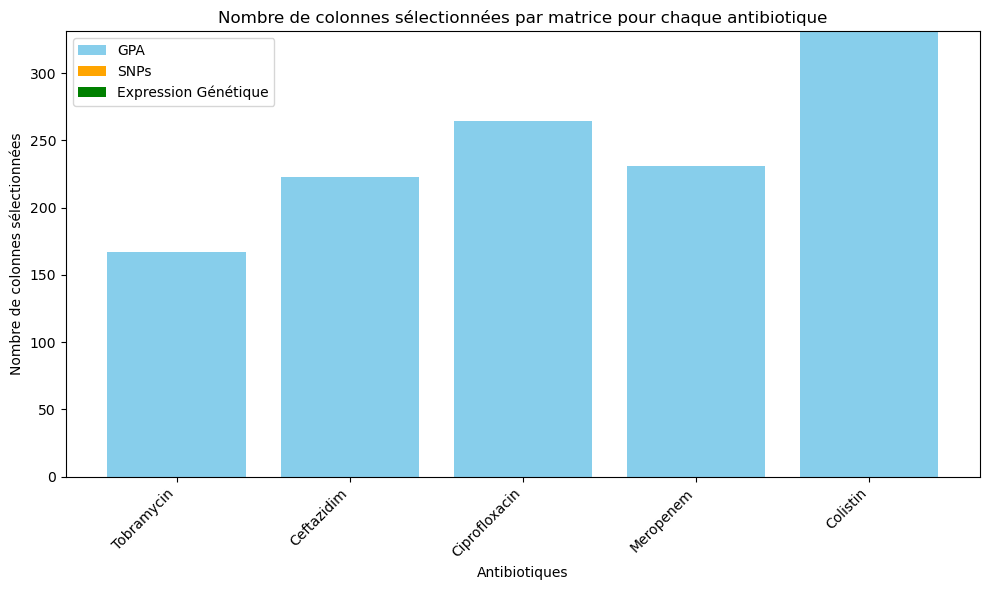

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'result_svm.csv' 
data = pd.read_csv(file_path, sep=';')

data['Nb_Colonnes_GPA'] = data['Colonnes_GPA'].apply(lambda x: len(eval(x)))
data['Nb_Colonnes_SNPs'] = data['Colonnes_SNPs'].apply(lambda x: len(eval(x)))
data['Nb_Colonnes_Genexp'] = data['Colonnes_Expression_Genetique'].apply(lambda x: len(eval(x)))

antibiotiques = data['Antibiotique']
gpa_counts = data['Nb_Colonnes_GPA']
snps_counts = data['Nb_Colonnes_SNPs']
genexp_counts = data['Nb_Colonnes_Genexp']

plt.figure(figsize=(10, 6))
plt.bar(antibiotiques, gpa_counts, label='GPA', color='skyblue')
plt.bar(antibiotiques, snps_counts, bottom=gpa_counts, label='SNPs', color='orange')
plt.bar(antibiotiques, genexp_counts, bottom=gpa_counts + snps_counts, label='Expression Génétique', color='green')

plt.xlabel('Antibiotiques')
plt.ylabel('Nombre de colonnes sélectionnées')
plt.title('Nombre de colonnes sélectionnées par matrice pour chaque antibiotique')
plt.xticks(rotation=45, ha='right')  # Rotation des labels pour une meilleure lisibilité
plt.legend()

plt.tight_layout()
plt.show()
